# Optimisation de la trajectoire d'un UAV
### Résolution avec la méthode discrètre LQT (Linear Quadratic Tracking) 

Abraham Bhérer-Constant 1906705

Théo Vernhes 1781853

Packages utilisés :

In [1]:
#using Pkg
#Pkg.add("Plots")
#Pkg.add("LinearAlgebra")

In [2]:
using Plots
using LinearAlgebra

### Problèmes rencontrés

Intégration de la gravité dans le modèle dynamique : RÉSOLU

Disctrétisation du modèle linéaire : RÉSOLU

Modification de l'algorithme LQT [eqn 36] : RÉSOLU (cf Discrete-Time Linear Quadratic Tracking System dans OPTIMAL CONTROL SYSTEMS par R. C. Dorf)

Matrice de poids optimale : 

    - R doit être une matrice symétrique définie positive
    
Solution diverge :

    - X_star diverge vers l'infini (L et Lg reste constant. Cela peut venir de la ? ou g)
    
    - X_star[5 et 6] = 0 pour tout k (doit tendre proche de 0 mais n'est pas constant ni exact)

## Modèle Dynamique Linéarisé

Parmètres du système dynamique :

In [3]:
Kt = 0.1 ;
W = 4.7088 ; # en N
gr = 9.81 ; # en m/s^2
m = W / gr ; # en kg
gravity = vcat(zeros(11, 1), - gr)

# Valeurs posées arbitrairement
d = 0.5 ; # en m
I_x = 1 ;
I_y = 1 ;
I_z = 1 ; 

U1_ini = W ; 

Paramètres de la simulation :

In [4]:
ti = 0 ; # temps initial en secondes
tf = 60 ; # temps de simulation en secondes
h = 0.01 ; # pas de temps en secondes
t = range(0, stop= tf , step = h)*I ; # vecteur temps

kf = size(t, 1) ;
k = kf ;

Construction du vecteur trajectoire désirée :

In [5]:
x = vcat(range(0, stop= 30 , step = h), range(30 - h, stop= 0 , step = -h)) ;
y = vcat(zeros(3000, 1), 5 .* ones(3001, 1))
z = ones(size(t))
z[(t .> 15) .& (t .<= 30)] = range(1 + h, stop = 16, step = h) ;
z[(t .> 30) .& (t .<= 45 )] = range(16 - h, stop = 1, step = - h) ;

In [6]:
# Éstimation des vitesses avec la méthode des différences finies :
x_dot_i = (x[2] - x[1])/h ;
x_dot_f = (x[kf] - x[kf - 1])/h ;
x_dot_n = (x[3:kf] - x[1:kf - 2]) ./ (2 *h ) ;

x_dot = vcat(x_dot_i, x_dot_n, x_dot_f)


y_dot_i = (x[2] - x[1])/h ;
y_dot_f = (x[kf] - x[kf - 1])/h ;
y_dot_n = (x[3:kf] - x[1:kf - 2]) ./ (2 *h ) ;

y_dot = vcat(y_dot_i, y_dot_n, y_dot_f)


z_dot_i = (x[2] - x[1])/h ;
z_dot_f = (x[kf] - x[kf - 1])/h ;
z_dot_n = (x[3:kf] - x[1:kf - 2]) ./ (2 *h ) ;

z_dot = vcat(z_dot_i, z_dot_n, z_dot_f) ;

In [7]:
# Vecteur trajectoire désirée: 
# r = [ϕ ϕ_dot θ θ_dot ψ ψ_dot x x_dot y y_dot z z_dot]'
r = hcat(zeros(kf, 6), x, x_dot, y, y_dot, z, z_dot)' ;

### Construction des matrice du système dynamique linéarisé

#### Matrice d'état A

In [8]:
A = zeros( 12, 12) ;
# Index matrice : A[ligne, colonne]
for i in 1:size( A, 2)
    if mod( i, 2) !== 0
        A[ i, i+1] = 1 ;
    end
end

A[ 8, 3] = U1_ini/m ;
A[ 8, 8] = -Kt / m ;

A[ 10, 1] = -U1_ini/m ;
A[ 10, 10] = -Kt / m ;

A[ 12, 12] = - Kt / m ;

#### Matrice d'entrée B

In [9]:
B = zeros(12, 4) ;
B[2, 2] = d / I_x ;
B[4, 3] = d / I_y ;
B[6, 4] = 1 / I_z ;
B[12, 1] = 1 / m ;

#### Matrice de sortie C

In [10]:
C = I(12) ;

## Calcul de la trajectoire et des contrôles optimaux

### Discrétisation du modèle

x[k+1] = x[k] + h * x_dot[k]

x[k+1] = x[k] + h * (A * x[k] + B * U[k] + gravity) où h : pas de temps (scalaire)

x[k+1] = (I + A * h) * x[k] + B * h * U[k] + gravity * h

x[k+1] = Ad * x[k] + Bd * U[k] + gravity * h


y[k+1] = C * x[k+1]

y[k+1] = Cd * x[k+1]

In [11]:
Ad = I + A * h ;

Bd = B * h ;

Cd = C ;

Calcul des paramètres de la méthode LQT

In [12]:
# Matrice de poids d'état
Q = Diagonal([100, 50, 10, 5, 0, 0, 100, 1, 100, 1, 1000, 0.1]);
#Q = I
#Q = Diagonal([100, 5, 100, 5, 100, 5, 100, 5, 100, 5, 100, 5]);

# Matrice de poids de contrôle
#R = Diagonal([10, 0.01, 0.01, 0.01]) ;
R = I

# Calcul des conditions finales et des solutions au temps final (kf) :
F = zeros(12,12) ;

P = Cd' * F * Cd ;
g = Cd' * F * r[1:12, kf] ;

U_star = zeros(4, size(r,2)) ;
X_star = zeros(size(r)) ;
X_star[1:12, kf] = r[1:12, kf] ;

Paramètres invariants dans le temps :

In [13]:
V = Cd' * Q * Cd ;

E = Bd * inv(R) * Bd' ;

In [14]:
# DEBUG

# store_g = [] ;
# push!(store_g, g)
# store_Lg = [] ;
# store_L = [] ;

In [15]:
# k = kf

### Backtracking avec LQT

In [16]:
while k !== 1
    k -= 1 ;
    
    L = (R + Bd' * P * Bd) \ Bd' * P * Ad ;
    Lg = (R + Bd' * P * Bd) \ Bd' ;
    
    X_star[1:12 , k] = (Ad - Bd * L) \ (X_star[1:12, k+1] - Bd * Lg * g - gravity * h);
    U_star[1:4,  k] = - L * X_star[1:12, k] + Lg * g ;
    
    g = (Ad' - Ad' * P / (I + E * P) * E) * g + Cd' * Q * r[1:12, k] ;
    P = Ad' * P / (I + E * P) * Ad + V;
    
    # DEBUG
    # push!(store_g, g) ;
    # push!(store_Lg, Lg)
    # push!(store_L, L)
end

## Résultats de l'algorithme

Graphique : X(t)

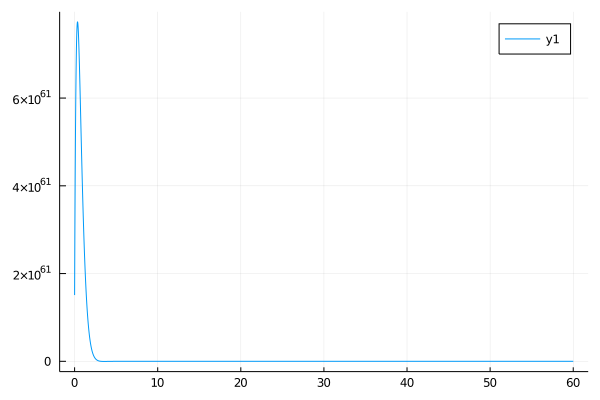

In [17]:
plot(t, X_star[7, :])

Graphique : Y(t)

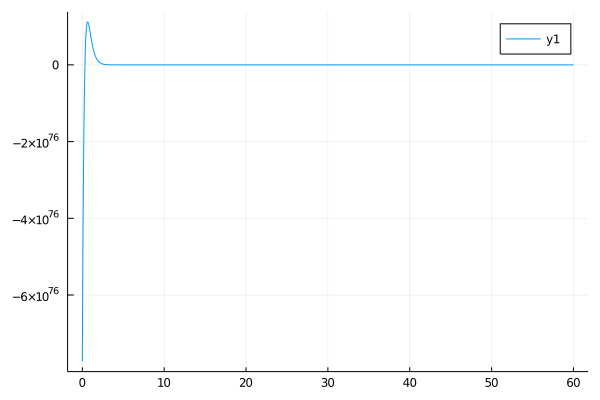

In [18]:
plot(t, X_star[9, :])

Graphique : Z(t)

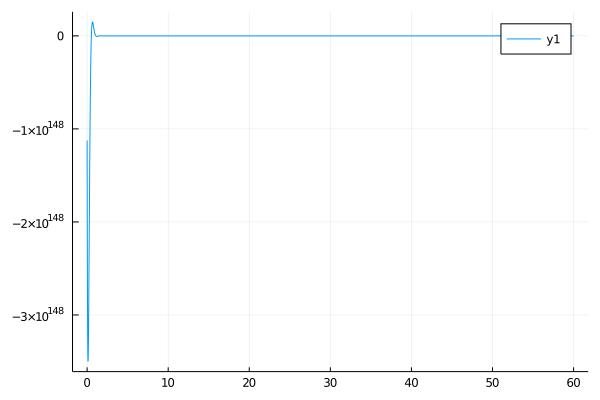

In [19]:
plot(t, X_star[11, :])

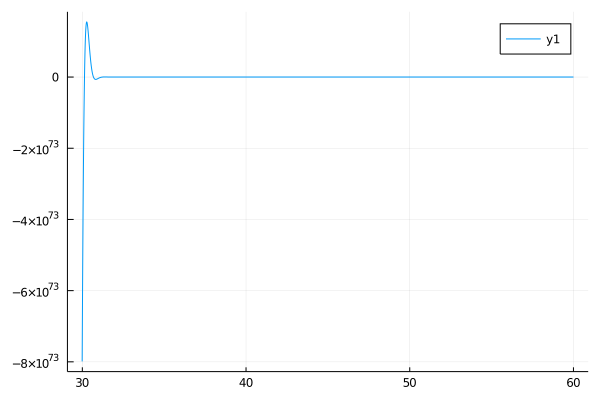

In [22]:
plot(t[3000:kf], X_star[11, 3000:kf])

La solution diverge dès le début et fluctue avec des amplitudes de plus en plus importantes

In [20]:
# Commandes optimales
U_star

4×6001 Matrix{Float64}:
  2.80663e150   2.62105e150  …  -0.00330047  -0.000404827  0.0  0.0
  5.50357e78    5.31613e78       0.0          0.0          0.0  0.0
 -4.64195e63   -4.52382e63       0.0          0.0          0.0  0.0
  0.0           0.0              0.0          0.0          0.0  0.0

In [21]:
# Trajectoire idéale
X_star

12×6001 Matrix{Float64}:
  1.98646e77    1.90974e77    1.83578e77   …   0.0         0.0         0.0
 -7.67136e77   -7.39618e77   -7.13037e77       0.0         0.0         0.0
 -2.25823e62   -2.17909e62   -2.10228e62       0.0         0.0         0.0
  7.9138e62     7.6817e62     7.45551e62       0.0         0.0         0.0
  0.0           0.0           0.0              0.0         0.0         0.0
  0.0           0.0           0.0          …   0.0         0.0         0.0
  1.51038e61    1.95786e61    2.38226e61       0.0200627   0.0100209   0.0
  4.47486e62    4.244e62      4.02139e62      -1.00418    -1.00209    -1.0
 -7.73168e76   -7.26952e76   -6.82782e76       5.02006     5.01002     5.0
  4.62152e77    4.41702e77    4.22048e77      -1.00418    -1.00209    -1.0
 -1.12383e148  -1.57994e148  -1.97663e148  …   1.01711     1.00904     1.0
 -4.56114e149  -3.96692e149  -3.4126e149      -0.807356   -0.903783   -1.0